In [1]:
# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

True

## A multi-agent workflow using LangGraph
### Synopsis
Though AI is far from Skynet, it's powerful if you take the time to tell it what you want.</br>
In this case, using the LangGraph / LangChain libraries building something interesting doesn't take a ton of work. 
### Motivation
Social media is filled with  "gotcha posts" of users showing the results of seemingly clear Chat GPT queries which give nonsensical results. Though these posts help dispel some of the GenAI hype, they imply that the tool is not all that useful. In this case, I got some existing boilerplate code, made a few changes and here you go.

In [2]:
from langgraph.prebuilt import create_react_agent
from langchain_tavily import TavilySearch # For web search
from langchain_experimental.utilities import PythonREPL
from typing import Annotated
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.messages import convert_to_messages
from openai import OpenAI

client = OpenAI()

# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

# Define chat model based on llm
model = init_chat_model("openai:gpt-4.1")
#model = init_chat_model("openai:gpt-5")
#model = init_chat_model("anthropic:claude-sonnet-4-20250514")
#model = init_chat_model("ollama:gpt-oss:20b")
code_model = model

# helper functions
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )



def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [3]:

# Define tools
    # For research agent
web_search = TavilySearch(max_results=3)


# For image generator agent
repl = PythonREPL()
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your image."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# For image generation agent
def genImage(input)->str:
    '''Generate an image based on a text prompt'''
    response = client.images.generate(
        model="dall-e-3",
        prompt = input,
        size = "1024x1024",
        quality = "hd",
        n=1,
    )
    url = response.data[0].url
    return url

def saveImage(url:str, filename:str)->str:
    '''Save an image from a URL to a local file'''
    import requests
    from PIL import Image
    from io import BytesIO
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    if not filename.endswith(".png"):
        filename = f"{filename}.png"
    else:
        filename = '.'.join(filename.split('.')[:2])
    img.save(filename)
    img.show()
    return filename

def saveThumbnail(filename:str, thumbnail_filename:str)->str:
    '''Create and save a 100x100 pixel thumbnail of an image'''
    from PIL import Image
    img = Image.open(filename)
    img.thumbnail((100, 100))
    if not thumbnail_filename.endswith(".png"):
        thumbnail_filename = f"{thumbnail_filename}.png"
    else:
        thumbnail_filename = '.'.join(thumbnail_filename.split('.')[:2])
    img.save(thumbnail_filename)
    return thumbnail_filename

In [4]:
# Define agents

image_generation_agent = create_react_agent(
    model=model,
    tools=[genImage, saveImage, saveThumbnail],
    name="image_generation_agent",
    prompt=make_system_prompt(
        "You are an image generation agent.\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with image-generation tasks, do not do any research, math or chart generation.\n"
        "- You have access to three tools: genImage, saveImage and saveThumbnail. Use these tools to generate and save the image based on the user's request."
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)


# Research agent
research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_agent",
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math or chart generation\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)

image_download_agent = create_react_agent(
    model=model,
    tools=[web_search, saveImage, saveThumbnail],
    name="image_download_agent",
    prompt=(
        "You are an image download agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with image download tasks, DO NOT do any math or chart generation\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)



In [5]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

# Initialize supervisor
supervisor = create_supervisor(
    model=model,
    agents=[research_agent, image_generation_agent],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        #"- an image download agent. Assign tasks to download images from the web, save them, and create thumbnails."
        "- an image generation agent. Assign tasks to generate images, save them and create thumbnails."
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import os

# Load your images (replace with your image paths)
# Example: Create dummy images for demonstration
import glob

def display_image_grid():
    def find_images_glob(folder_path):
        image_files = []
        # You can specify multiple patterns for different image types
        image_files.extend(glob.glob(os.path.join(folder_path, '*thumbnail.png')))
        images = [Image.open(image_file) for image_file in image_files]
        return images

    images = find_images_glob('.')

    # Create a figure
    fig = plt.figure(figsize=(20., 5.))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.2)

    # Iterate over the grid and display images
    for ax, im in zip(grid, images):
        ax.imshow(im) # Ensure image data type is appropriate
        ax.axis('off') # Turn off axis labels and ticks
        athlete_name = ' '.join(os.path.splitext(os.path.basename(im.filename))[0].split('_')[:-1])
        country_name = athlete_name.split()[-1]
        athlete_name = ' '.join(athlete_name.split()[:-1])
        ax.set_title(f"{athlete_name} ({country_name})", fontsize=9)  # Set title to filename without extension
    plt.show()

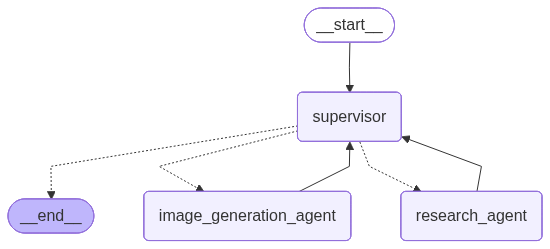

In [7]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [8]:
for event in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Identify the 10 largest countries in Europe."
                "For each country, do the following:"
                "1. Tell me the name of its most famous athlete"
                "2. Generate an image of the athlete."
                "3. Save the image as '{athlete}_{country}.png'."
                "4. Create a thumbnail of the generated athlete's image."
                "5. Save the thumbnail as '{athlete}_{country}_thumbnail.png'."
            }
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 250},
):
    pretty_print_messages(event, last_message=True)

display_image_grid()

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_image_generation_agent

Successfully transferred to image_generation_agent


Update from node image_generation_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The following tasks were completed for the 10 largest countries in Eur

AttributeError: type object 'Image' has no attribute 'open'

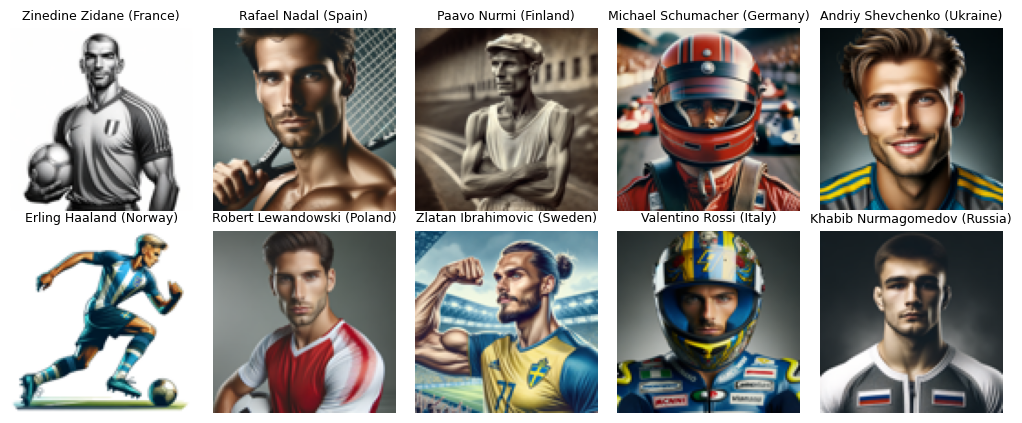

In [ ]:
display_image_grid()